# 1. Link ATAC-seq peaks to expression 

The ATAC-seq gives information about peak intensities per sample and the RNA-seq gives gene expression levels per sample. Wen want to correlate between chromatin and expresion.

We will answer the questions:
- Does this regulatory region (peak) affect this gene?
- Is that relationship consistent across many samples?

Before starting, I want to make sure that ATAC-seq and the RNA-seq datasets align to enable further analysis.

In [80]:
import pandas as pd

# Loading the data
atac_peak_matrix = pd.read_csv("ATAC_high_var.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:]  # dropping metadata columns
atac_transposed_df = atac_signal_matrix.T

rna_df = pd.read_csv("rna_filtered_abT_Tact_Stem.csv", index_col=0)
rna_df.T
rna_transposed_df = rna_df.T

from sklearn.preprocessing import StandardScaler
rna_scaled_array = StandardScaler().fit_transform(rna_transposed_df)
rna_scaled_df = pd.DataFrame(rna_scaled_array, index=rna_transposed_df.index, columns=rna_transposed_df.columns)

# Ensuring sample alignment
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]

We can only correlate ATAC and RNA from the same samples. That is why we did the sample alignment so that both matrices refer to the same cell type.

Before continuing we want to make sure that this alignment worked correctly.

In [81]:
# Making sure datasets are aligned
## Comparing shapes
print("ATAC shape:", atac.shape)
print("RNA shape:", rna.shape)

## Comparing indices
for sample_a, sample_r in zip(atac.index, rna.index):
    print(f"ATAC: {sample_a}  |  RNA: {sample_r}")

## Inspecting common samples 
print("Common samples used for correlation:")
print(list(common_samples))


ATAC shape: (28, 75857)
RNA shape: (28, 17535)
ATAC: preT.DN1.Th  |  RNA: preT.DN1.Th
ATAC: preT.DN2a.Th  |  RNA: preT.DN2a.Th
ATAC: preT.DN2b.Th  |  RNA: preT.DN2b.Th
ATAC: preT.DN3.Th  |  RNA: preT.DN3.Th
ATAC: T.DN4.Th  |  RNA: T.DN4.Th
ATAC: T.ISP.Th  |  RNA: T.ISP.Th
ATAC: T.DP.Th  |  RNA: T.DP.Th
ATAC: T.4.Th  |  RNA: T.4.Th
ATAC: T.8.Th  |  RNA: T.8.Th
ATAC: T.4.Nve.Sp  |  RNA: T.4.Nve.Sp
ATAC: T.4.Nve.Fem.Sp  |  RNA: T.4.Nve.Fem.Sp
ATAC: T.4.Sp.aCD3+CD40.18hr  |  RNA: T.4.Sp.aCD3+CD40.18hr
ATAC: T.8.Nve.Sp  |  RNA: T.8.Nve.Sp
ATAC: Treg.4.25hi.Sp  |  RNA: Treg.4.25hi.Sp
ATAC: Treg.4.FP3+.Nrplo.Co  |  RNA: Treg.4.FP3+.Nrplo.Co
ATAC: T8.TN.P14.Sp  |  RNA: T8.TN.P14.Sp
ATAC: T8.TE.LCMV.d7.Sp  |  RNA: T8.TE.LCMV.d7.Sp
ATAC: T8.MP.LCMV.d7.Sp  |  RNA: T8.MP.LCMV.d7.Sp
ATAC: T8.Tcm.LCMV.d180.Sp  |  RNA: T8.Tcm.LCMV.d180.Sp
ATAC: T8.Tem.LCMV.d180.Sp  |  RNA: T8.Tem.LCMV.d180.Sp
ATAC: NKT.Sp  |  RNA: NKT.Sp
ATAC: NKT.Sp.LPS.3hr  |  RNA: NKT.Sp.LPS.3hr
ATAC: NKT.Sp.LPS.18hr  |  RNA: NKT.

We have established that the datasets align. 

Now, want to create a gene -> TSS coordinate table to be able to annotate the peaks later. We are using the annotations file (refFlat) for this step.

In [82]:
ref = pd.read_csv("refFlat", sep="\t", header=None)
ref.head()
ref.shape
len(ref)

47382

In [83]:
import pandas as pd
from scipy.spatial import cKDTree

# Loading and naming refFlat columns 
ref = pd.read_csv("refFlat", sep="\t", header=None)

ref.columns = [
    "gene_name", "transcript_id", "chrom", "strand",
    "tx_start", "tx_end", "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# Computing strand-aware TSS 
ref["tss"] = ref.apply(
    lambda row: row["tx_start"] if row["strand"] == "+" else row["tx_end"],
    axis=1
)

# Keeping one TSS per gene
tss_table = ref.groupby("gene_name").first().reset_index()
tss_table = tss_table[["gene_name", "chrom", "tss", "strand"]].rename(columns={"gene": "gene_symbol"})

print("TSS table shape:", tss_table.shape)
tss_table.head()


TSS table shape: (26214, 4)


,gene_name,chrom,tss,strand
0,0610005C13Rik,chr7,45575176,-
1,0610009B22Rik,chr11,51688634,-
2,0610009E02Rik,chr2,26445923,+
3,0610009L18Rik,chr11,120348677,+
4,0610010F05Rik,chr11,23633631,-


Now, we want to match ATAC peaks to nearest TSS. For that, we will find the nearest gene to each peak and compute the distance to that gene's TSS. We will use KD-Tree for this. It will give us information about which gene is likely regulated by which peak.

In [84]:
# Loading ATAC peak file
peaks = pd.read_csv("peaks_tss_distance.csv") 
peaks = peaks.rename(columns={"ImmGenATAC1219.peakID": "peak_id"})

# Create BED-style table 
peak_table = peaks[["peak_id", "chrom", "peak_center"]].copy()
peak_table["start"] = peak_table["peak_center"]
peak_table["end"] = peak_table["peak_center"] + 1  # peak summit +1 bp to make it computable

# Matching each peak to the nearest TSS
from scipy.spatial import cKDTree

tss_links = []

for chrom in peak_table["chrom"].unique():
    peaks_chr = peak_table[peak_table["chrom"] == chrom]
    tss_chr = tss_table[tss_table["chrom"] == chrom]

    if tss_chr.empty:
        continue

    # Using KDTree for fast nearest-neighbor matching
    tree = cKDTree(tss_chr["tss"].values.reshape(-1, 1))
    dists, idxs = tree.query(peaks_chr["peak_center"].values.reshape(-1, 1), k=1)

    matched_genes = tss_chr.iloc[idxs]["gene_name"].values
    matched_tss = tss_chr.iloc[idxs]["tss"].values
    matched_strands = tss_chr.iloc[idxs]["strand"].values

    result = peaks_chr.copy()
    result["gene_symbol"] = matched_genes
    result["tss"] = matched_tss
    result["strand"] = matched_strands
    
    # Computing signed distance to TSS based on strand
    result["signed_distance_to_tss"] = result.apply(
        lambda row: row["peak_center"] - row["tss"] if row["strand"] == "+" else row["tss"] - row["peak_center"],
        axis=1
    )

    # Keeping absolute value for safety
    result["distance_to_tss"] = result["signed_distance_to_tss"].abs()
    
    tss_links.append(result)

linked_df = pd.concat(tss_links, ignore_index=True)

# Saving result
linked_df.to_csv("peak_to_gene_annotated.csv", index=False)


The BED-style table refers to a table representing genomic features. It is used to standardize genomic region representation. Here, it represents ATAC peaks as genomic coordinated and matches each peak to the nearest TSS using spatial distance. This distance is computed as the difference between the peak summit and the TSS position on the same chromosome. We also added differentiation between up- and downstream elements. 

We can now link peaks to genes by correlating chromatin accessibility with gene expression across the 28 samples. Because there were a lot of errors that needed fixing, in this first cell I am reloading the datasets and aligning them again.

In [85]:
# Re-loading full ATAC matrix with metadata
full_atac = pd.read_csv("ATAC_high_var.csv")

# Extracting signal matrix and assigning peak IDs as index
atac_signal_matrix = full_atac.iloc[:, 8:]  # signal: shape (512595 rows, 29 columns)
atac_signal_matrix.index = full_atac["ImmGenATAC1219.peakID"].astype(str)  # assigning to rows

# Transposing so rows = samples, columns = peak IDs
atac_transposed_df = atac_signal_matrix.T  # shape = (29 samples, 512595 peaks)

# Aligning with RNA
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]


In [86]:
print("Signal matrix shape (rows = peaks):", atac_signal_matrix.shape)
print("First 5 peak IDs (index):", atac_signal_matrix.index[:5].tolist())


Signal matrix shape (rows = peaks): (75857, 30)
First 5 peak IDs (index): ['ImmGenATAC1219.peak_69', 'ImmGenATAC1219.peak_77', 'ImmGenATAC1219.peak_83', 'ImmGenATAC1219.peak_84', 'ImmGenATAC1219.peak_93']


In [87]:
atac_transposed_df = atac_signal_matrix.T
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]


In [88]:
import pandas as pd
from scipy.stats import spearmanr
from tqdm import tqdm

# Loading the peak–TSS annotated file with signed distances
annot = pd.read_csv("peak_to_gene_annotated.csv")

# Filtering to peaks within ±100 kb
annot = annot[annot["signed_distance_to_tss"].abs() <= 100000]

print( annot["signed_distance_to_tss"].head(10) )
print( annot["signed_distance_to_tss"].describe() )

# ─── Step 2: Separate upstream (neg) vs downstream (pos) peaks ───
upstream  = annot[ annot["signed_distance_to_tss"] <  0 ].copy()
downstream = annot[ annot["signed_distance_to_tss"] >  0 ].copy()

print(f"Upstream pairs:   {len(upstream):,}")
print(f"Downstream pairs: {len(downstream):,}")





0     28775
1      6702
2       875
3       616
4    -50220
5    -74341
6    -74643
8     96425
9     37778
10    37418
Name: signed_distance_to_tss, dtype: int64
count    68486.000000
mean      3612.887510
std      29845.386224
min     -99926.000000
25%      -2863.000000
50%        157.000000
75%      12375.750000
max      99990.000000
Name: signed_distance_to_tss, dtype: float64
Upstream pairs:   31,155
Downstream pairs: 37,290


### Compute correlations for **upstream** peaks (distance < 0)


In [89]:
# ─── Step 3: Correlate upstream peak–gene pairs ───
results_up = []
for _, row in tqdm(upstream.iterrows(), total=len(upstream)):
    peak = row["peak_id"]
    gene = row["gene_symbol"]
    dist = row["signed_distance_to_tss"]
    try:
        rho, pval = spearmanr(atac[peak], rna[gene])
        results_up.append({
            "peak_id": peak,
            "gene_symbol": gene,
            "signed_distance_to_tss": dist,
            "spearman_rho": rho,
            "pval": pval
        })
    except Exception:
        continue

# Build DataFrame and save
cor_up = pd.DataFrame(results_up)
cor_up.to_csv("upstream_peak_gene_correlations.csv", index=False)
print(f"Upstream correlations done: {len(cor_up):,} pairs")


100%|██████████| 31155/31155 [00:09<00:00, 3153.59it/s]


Upstream correlations done: 25,334 pairs


### Step 4: Correlate **downstream** peak–gene pairs (distance > 0)


In [90]:
from tqdm import tqdm
from scipy.stats import spearmanr
import pandas as pd

results_down = []
for _, row in tqdm(downstream.iterrows(), total=len(downstream)):
    peak = row["peak_id"]
    gene = row["gene_symbol"]
    dist = row["signed_distance_to_tss"]
    try:
        rho, pval = spearmanr(atac[peak], rna[gene])
        results_down.append({
            "peak_id": peak,
            "gene_symbol": gene,
            "signed_distance_to_tss": dist,
            "spearman_rho": rho,
            "pval": pval
        })
    except Exception:
        continue

# Build DataFrame and save
cor_down = pd.DataFrame(results_down)
cor_down.to_csv("downstream_peak_gene_correlations.csv", index=False)
print(f"Downstream correlations done: {len(cor_down):,} pairs")


100%|██████████| 37290/37290 [00:10<00:00, 3714.59it/s]


Downstream correlations done: 31,076 pairs


Here I noticed that we have a different number of pairs than we initially filtered with genes within 100kb... 


I looked at the reason for this

In [91]:
# how many we attempted?
print("Attempted:", len(upstream))

# how many succeeded?
print("Succeeded:", len(results_up))

# how many failed?
failures = len(upstream) - len(results_up)
print("Failures:", failures)


Attempted: 31155
Succeeded: 25334
Failures: 5821


In [92]:
failed = []
for _, row in upstream.iterrows():
    peak, gene = row["peak_id"], row["gene_symbol"]
    try:
        _ = spearmanr(atac[peak], rna[gene])
    except:
        failed.append((peak, gene))
print("First 10 failures:", failed[:10])


First 10 failures: [('ImmGenATAC1219.peak_575', '1700034P13Rik'), ('ImmGenATAC1219.peak_631', 'Mcmdc2'), ('ImmGenATAC1219.peak_632', 'Mcmdc2'), ('ImmGenATAC1219.peak_639', 'Mcmdc2'), ('ImmGenATAC1219.peak_641', 'Mcmdc2'), ('ImmGenATAC1219.peak_644', 'Mcmdc2'), ('ImmGenATAC1219.peak_645', 'Mcmdc2'), ('ImmGenATAC1219.peak_799', 'Mir467e'), ('ImmGenATAC1219.peak_802', 'Mir467e'), ('ImmGenATAC1219.peak_804', 'Mir467e')]


In [93]:
import numpy as np

for peak, gene in failed[:5]:
    print(f"\n▶️ Pair: {peak} ↔ {gene}")

    # Check presence in ATAC
    if peak not in atac.columns:
        print("  ✖ Peak not found in ATAC matrix")
    else:
        vec_atac = atac[peak]
        print("  ✔ ATAC    → NaNs:", vec_atac.isna().sum(),
              ", unique:", vec_atac.nunique())

    # Check presence in RNA
    if gene not in rna.columns:
        print("  ✖ Gene not found in RNA matrix")
    else:
        vec_rna = rna[gene]
        print("  ✔ RNA     → NaNs:", vec_rna.isna().sum(),
              ", unique:", vec_rna.nunique())



▶️ Pair: ImmGenATAC1219.peak_575 ↔ 1700034P13Rik
  ✔ ATAC    → NaNs: 0 , unique: 28
  ✖ Gene not found in RNA matrix

▶️ Pair: ImmGenATAC1219.peak_631 ↔ Mcmdc2
  ✔ ATAC    → NaNs: 0 , unique: 28
  ✖ Gene not found in RNA matrix

▶️ Pair: ImmGenATAC1219.peak_632 ↔ Mcmdc2
  ✔ ATAC    → NaNs: 0 , unique: 28
  ✖ Gene not found in RNA matrix

▶️ Pair: ImmGenATAC1219.peak_639 ↔ Mcmdc2
  ✔ ATAC    → NaNs: 0 , unique: 27
  ✖ Gene not found in RNA matrix

▶️ Pair: ImmGenATAC1219.peak_641 ↔ Mcmdc2
  ✔ ATAC    → NaNs: 0 , unique: 28
  ✖ Gene not found in RNA matrix


“genes.within.100Kb” on the ATAC side is simply “any gene whose TSS sits within 100 kb of this peak” based on the genome coordinates—no expression data considered.

Your RNA matrix only contains genes that showed up in your experiment (everything else got filtered out as unexpressed or too low).

Looking at the number of these

In [94]:
# all genes in your annotation
annot_genes = set(annot["gene_symbol"])    

# all genes in your RNA matrix
rna_genes   = set(rna.columns)              

# ghost genes = annotated but not in RNA
ghosts = annot_genes - rna_genes             

print(f"{len(ghosts):,} genes in annot but missing in RNA")  
print(list(ghosts)[:10])  # show the first 10 names


3,624 genes in annot but missing in RNA
['Mir124a-3', 'LOC105245613', 'Cyp4a30b', 'Dnhd1', 'Cenpx', 'Mir1843b', 'Gm13291', 'F930026P19Rik', 'H2-M10.4', 'Marchf9']


# correlating upstream peak–gene pairs → cor_up


FOR THE UPSTREAM:

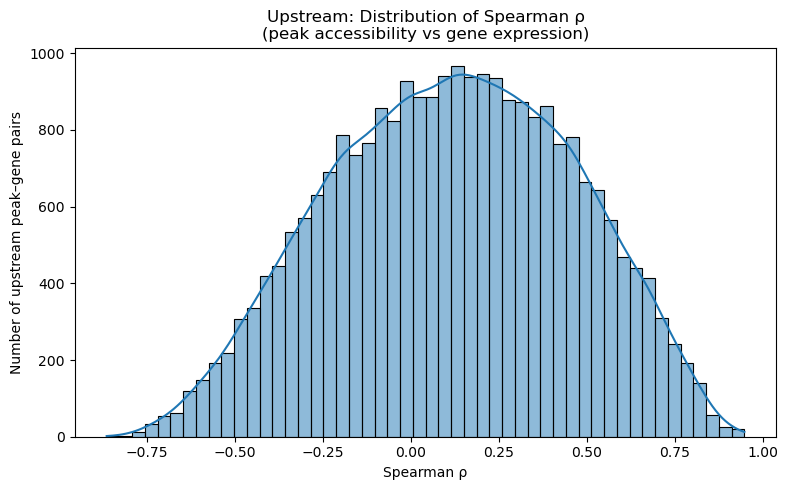

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(
    cor_up["spearman_rho"],
    bins=50,
    kde=True,
    stat="count"
)
plt.title("Upstream: Distribution of Spearman ρ\n(peak accessibility vs gene expression)")
plt.xlabel("Spearman ρ")
plt.ylabel("Number of upstream peak–gene pairs")
plt.tight_layout()
plt.show()



# correlating downstream peak–gene pairs → cor_down


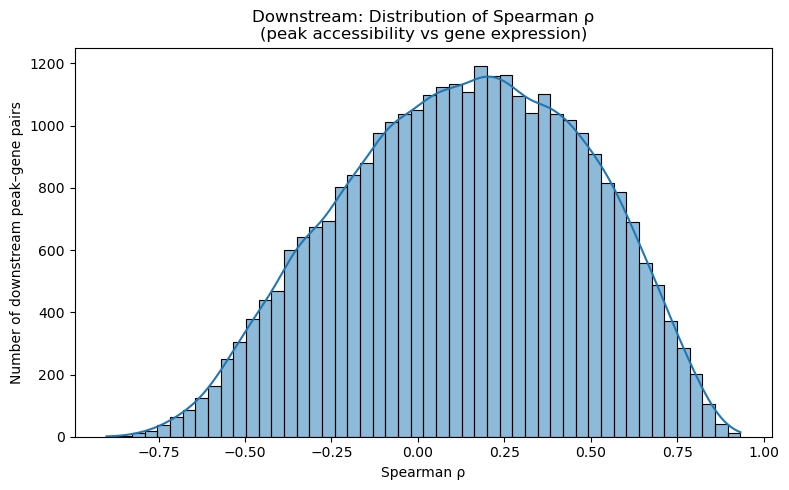

In [96]:
plt.figure(figsize=(8,5))
sns.histplot(
    cor_down["spearman_rho"],
    bins=50,
    kde=True,
    stat="count"
)
plt.title("Downstream: Distribution of Spearman ρ\n(peak accessibility vs gene expression)")
plt.xlabel("Spearman ρ")
plt.ylabel("Number of downstream peak–gene pairs")
plt.tight_layout()
plt.show()


In [97]:
# Numeric summaries
up_stats   = cor_up["spearman_rho"].describe()
down_stats = cor_down["spearman_rho"].describe()

print("Upstream Spearman ρ:\n", up_stats, "\n")
print("Downstream Spearman ρ:\n", down_stats, "\n")

# Proportion of “strong” correlations (|ρ| > 0.5)
up_strong_pos = (cor_up["spearman_rho"] > 0.5).mean()
up_strong_neg = (cor_up["spearman_rho"] < -0.5).mean()
down_strong_pos = (cor_down["spearman_rho"] > 0.5).mean()
down_strong_neg = (cor_down["spearman_rho"] < -0.5).mean()

print(f"Upstream strong +ρ (>0.5): {up_strong_pos:.2%}")
print(f"Upstream strong –ρ (<–0.5): {up_strong_neg:.2%}")
print(f"Downstream strong +ρ (>0.5): {down_strong_pos:.2%}")
print(f"Downstream strong –ρ (<–0.5): {down_strong_neg:.2%}")


Upstream Spearman ρ:
 count    25334.000000
mean         0.116951
std          0.341999
min         -0.865353
25%         -0.137931
50%          0.124247
75%          0.377747
max          0.947311
Name: spearman_rho, dtype: float64 

Downstream Spearman ρ:
 count    31076.000000
mean         0.133338
std          0.344467
min         -0.900930
25%         -0.119321
50%          0.146682
75%          0.401204
max          0.933224
Name: spearman_rho, dtype: float64 

Upstream strong +ρ (>0.5): 14.68%
Upstream strong –ρ (<–0.5): 3.38%
Downstream strong +ρ (>0.5): 16.42%
Downstream strong –ρ (<–0.5): 3.35%


Center: Both upstream and downstream distributions are centered slightly above zero , indicating a modest overall positive association between accessibility and expression.

Spread: The standard deviation  shows a wide range of behaviors—many peaks are uncorrelated (ρ≈0), but quite a few are strongly linked.

Tails:

Upstream: ~14% of pairs show strong positive correlations (ρ>0.5), ~3% strong negative (ρ<–0.5).

Downstream: ~16% strong positive, ~3% strong negative.

Peaks with ρ>0.5 are candidate enhancers (accessibility tracks expression), while those with ρ<–0.5 might be repressors or reflect more complex regulation

BUT: 

Promoters are almost always “open” when the gene is on.

Distal enhancers might be active only in a subset of cell types or conditions.

If you assign both to the same gene, the promoter’s flat-high signal and the enhancer’s flat-low signal will average out to something uncorrelated with expression.

## Correlation vs. Distance to TSS

We’ll now visualize how Spearman ρ varies with genomic distance **separately** for upstream (distance < 0) and downstream (distance > 0) peak–gene pairs.


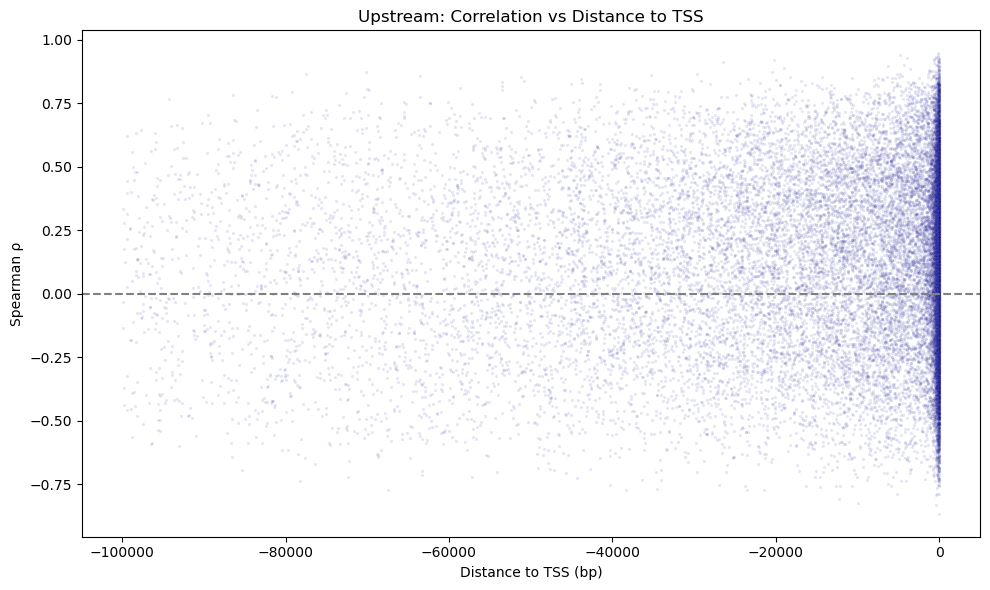

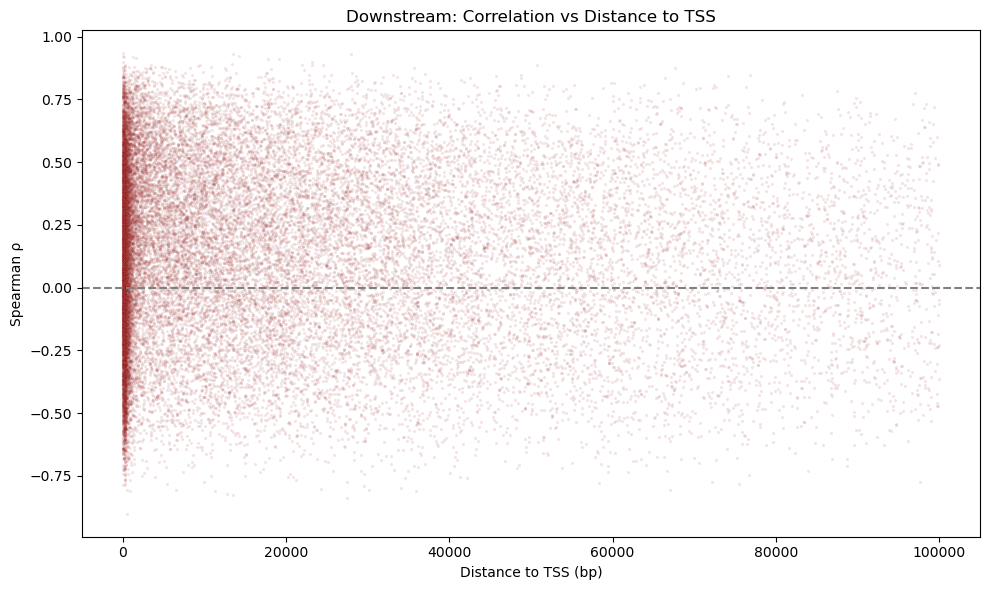

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# ─── Upstream ────────────────────────────────────────────────────
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=cor_up,
    x="signed_distance_to_tss",
    y="spearman_rho",
    alpha=0.1,
    s=5,
    color="darkblue",
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Upstream: Correlation vs Distance to TSS")
plt.xlabel("Distance to TSS (bp)")    # negative values = upstream
plt.ylabel("Spearman ρ")
plt.tight_layout()
plt.show()

# ─── Downstream ──────────────────────────────────────────────────
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=cor_down,
    x="signed_distance_to_tss",
    y="spearman_rho",
    alpha=0.1,
    s=5,
    color="darkred",
)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Downstream: Correlation vs Distance to TSS")
plt.xlabel("Distance to TSS (bp)")    # positive values = downstream
plt.ylabel("Spearman ρ")
plt.tight_layout()
plt.show()


**Correlation vs Distance to TSS (all peak-gene pairs)**

This plot confirms our expections - the most peak-gene pairs are located close to the gene-TSS, possibily proximal CREs with a direct regulatory effect on gene expression. With increasing distance to TSS the vertical spread decreases which is expected as those peaks have weaker correlations with gene expression.

# 2. Where are CREs located with respect to TSS?

We want to classify peaks based on genomic location relative to the TSS:
- promoter
- proximal enhancer
- distal enhancer
- intergenic/intronic

The first step is to classify each CRE by distance to TSS. We are going to do this qualitatively, using visual patterns to definte promoter/enhancer classes based on functional enrichment around TSS.

First, we want to plot peak counts by distance to TSS to see where peaks cluster around TSSs.

- **Upstream**: signed_distance_to_tss < 0  
- **Downstream**: signed_distance_to_tss > 0  

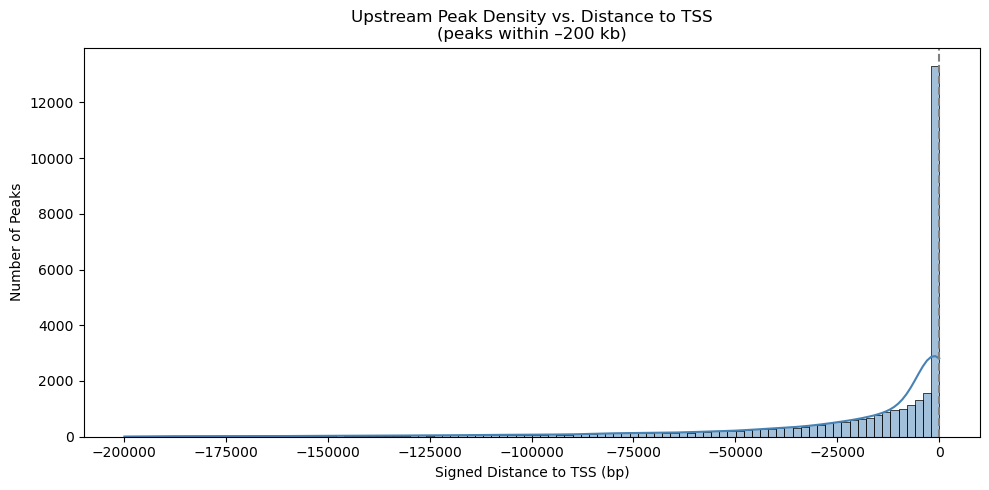

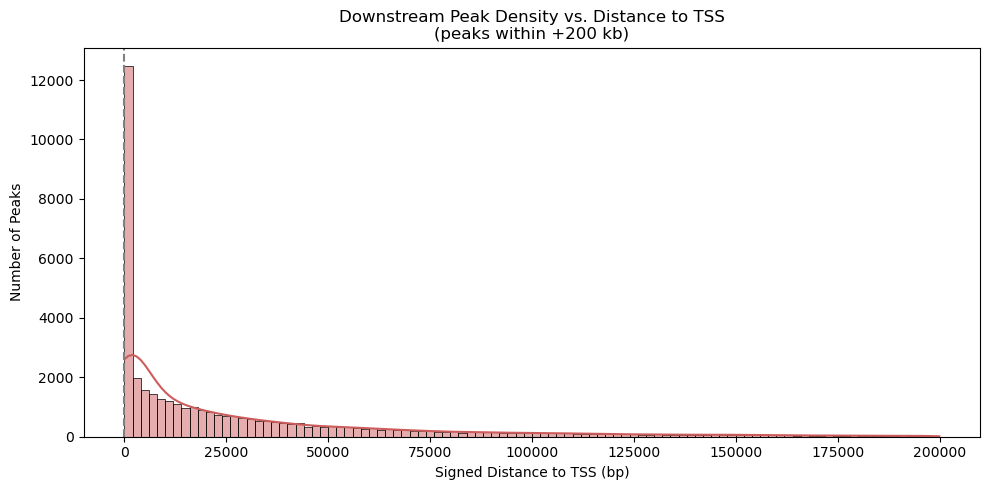

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# load your annotated peak‐to‐gene file (with signed_distance_to_tss)
annot = pd.read_csv("peak_to_gene_annotated.csv")

# restrict to ±200 kb to avoid long tails
subset = annot[annot["signed_distance_to_tss"].abs() <= 200_000]

# ─── Upstream ────────────────────────────────────────────────────
plt.figure(figsize=(10,5))
sns.histplot(
    data=subset[subset["signed_distance_to_tss"] < 0],
    x="signed_distance_to_tss",
    bins=100,
    kde=True,
    color="steelblue",
    stat="count"
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Upstream Peak Density vs. Distance to TSS\n(peaks within –200 kb)")
plt.xlabel("Signed Distance to TSS (bp)")   # negative = upstream
plt.ylabel("Number of Peaks")
plt.tight_layout()
plt.show()

# ─── Downstream ──────────────────────────────────────────────────
plt.figure(figsize=(10,5))
sns.histplot(
    data=subset[subset["signed_distance_to_tss"] > 0],
    x="signed_distance_to_tss",
    bins=100,
    kde=True,
    color="indianred",
    stat="count"
)
plt.axvline(0, color="gray", linestyle="--")
plt.title("Downstream Peak Density vs. Distance to TSS\n(peaks within +200 kb)")
plt.xlabel("Signed Distance to TSS (bp)")   # positive = downstream
plt.ylabel("Number of Peaks")
plt.tight_layout()
plt.show()


**Fig. 3: Peak denisity vs. distance to TSS**

The sharp spike at 0 bp shows a large number of ATAC-seq peaks that fall directly at or near the TSSs as we would expect for promoter regions. The signal density gradually decreases as distance from TSS increases suggesting that those peaks are connected to enhancers since they tend to be more distally located. 


Based on the density plots, we’ll call:

- **Promoters**: within ±1 kb of the TSS  
- **Proximal enhancers**: 1 kb–10 kb from the TSS  
- **Distal enhancers**: 10 kb–100 kb from the TSS  
- **Other**: >100 kb away (we’ll ignore these for now)


To further see if these cutoffs make sense, we are going to use the Spearmap ρ values from the previous task to evaluate where functional regulation is strongest. In order to be able to do that, we are going to plot correlation stregth vs distance. --> i did not do this bc the plot seemed useless, is there another way? ask aidana

At this point we need to do a regression model. Right now we are saying there is a peak at a certain point, and it should be the pair of gene x because of its location. But we need to confirm that these pairs make sense. We want to get an R'2 value for each pair. 



We are grouping peak-gene pairs into five regions based on distance to nearest TSS:
- distal enhancers
- proximal enhancers
- upstream position 
- downstream position
- promoters 

In [113]:
import pandas as pd

# 1) define your initial, distance‐based labels
def assign_initial(dist, prom_cut=1_000, enh_cut=10_000):
    """
    - |dist| ≤ prom_cut    → Promoter
    - prom_cut < dist ≤ enh_cut  → Downstream Enhancer
    - -enh_cut ≤ dist < -prom_cut → Upstream Enhancer
    - otherwise                   → Unassigned
    """
    if abs(dist) <= prom_cut:
        return "Promoter"
    if  prom_cut < dist <= enh_cut:
        return "Downstream Enhancer"
    if -enh_cut <= dist < -prom_cut:
        return "Upstream Enhancer"
    return "Unassigned"

# apply to your df
cor_df["Region"] = cor_df["signed_distance_to_tss"].apply(assign_initial)


# 2) now enforce *one* promoter per gene—if a gene happens to have multiple peaks within ±1 kb,
#    keep only the *closest*; demote the others to "Enhancer"
def enforce_one_promoter(g):
    # find all peaks that we initially called "Promoter"
    prom_ix = g.index[g["Region"] == "Promoter"]
    if len(prom_ix) > 1:
        # pick the one with smallest abs(distance)
        dists = g.loc[prom_ix, "signed_distance_to_tss"].abs()
        keep = dists.idxmin()
        # everything else becomes (down or up) enhancer
        to_demote = prom_ix.difference([keep])
        g.loc[to_demote, "Region"] = (
            g.loc[to_demote, "signed_distance_to_tss"]
             .apply(lambda d: "Downstream Enhancer" if d > 0 else "Upstream Enhancer")
        )
    return g

cor_df = (
    cor_df
    .groupby("gene_symbol", group_keys=False)
    .apply(enforce_one_promoter)
    .reset_index(drop=True)
)

# 3) (optional) drop everything you don’t care about
#    e.g. if you want to *ignore* unassigned peaks entirely:
cor_df = cor_df[cor_df["Region"] != "Unassigned"].copy()

# now you have exactly the three classes you asked for:
print(cor_df.Region.value_counts())



Region
Downstream Enhancer    12746
Promoter               10687
Upstream Enhancer       8775
Name: count, dtype: int64


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_47427/3695641130.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(enforce_one_promoter)


**Table 1: Region categories (promoter, proximal downstream, proximal upstream, distal downstream, distal upstream)**

From the table we can gather that promoters and proximal regions have stronger functional links to gene expression than distal regions.

**Fig. 5: Boxplot. Spearman correlation by regions (distance to TSS)**

 It looks like functional regulatory interactions are most enriched just downstream of the TSS, then upstream, with weaker overall signal at the promoter itself or at more distal sites. --> IMPORTANT

In the last step, we want to connect each gene to the specific CREs that are near its TSS and show evidence of correlation. We will have a gene-centric map of regulatory elements. For that, we are going to assign distances based on the quantitative analysis and the defined cutoffs from Fig. 3 and Fig. 4. 

In [101]:
# Creating a gene-centric map of CREs

## Adding the signed distances to cor_df
if "signed_distance_to_tss" not in cor_df.columns:
    signed_distances = pd.read_csv("peak_to_gene_annotated.csv")[["peak_id", "gene_symbol", "signed_distance_to_tss"]]
    cor_df = pd.merge(cor_df, signed_distances, on=["peak_id", "gene_symbol"], how="inner")

## Defining regions based on Fig. 3 & Fig. 4
def assign_region(dist):
    if -1000 <= dist <= 1000:
        return "Promoter"
    elif -10000 <= dist < -1000:
        return "Proximal Upstream"
    elif 1000 < dist <= 10000:
        return "Proximal Downstream"
    elif -20000 <= dist < -10000:
        return "Distal Upstream"
    elif 10000 < dist <= 20000:
        return "Distal Downstream"
    else:
        return "Unassigned"

cor_df["Region"] = cor_df["signed_distance_to_tss"].apply(assign_region)

## Grouping by gene and region

### For each gene, list its peaks by region
grouped = cor_df.groupby(["gene_symbol", "Region"]).agg({
    "peak_id": list,
    "spearman_rho": list,
    "signed_distance_to_tss": list
}).reset_index()

## Saving output
grouped.to_csv("gene_regulatory_map.csv", index=False)
gene_map = pd.read_csv("gene_regulatory_map.csv")
gene_map.head()

,gene_symbol,Region,peak_id,spearman_rho,signed_distance_to_tss
0,0610005C13Rik,Distal Upstream,"['ImmGenATAC1219.peak_427236', 'ImmGenATAC1219...","[-0.238722441512202, -0.1735676353173739, -0.0...","[-14074, -14334, -16780, -18119]"
1,0610009B22Rik,Promoter,"['ImmGenATAC1219.peak_75289', 'ImmGenATAC1219....","[0.4176245210727969, 0.5424192665571976]","[-163, -479]"
2,0610009L18Rik,Promoter,"['ImmGenATAC1219.peak_95335', 'ImmGenATAC1219....","[0.1330231297526269, -0.083743842364532]","[-68, 185]"
3,0610009L18Rik,Proximal Downstream,"['ImmGenATAC1219.peak_95338', 'ImmGenATAC1219....","[-0.0848385331143951, 0.4969896004378763, 0.24...","[1272, 1591, 1844, 4901, 5153, 5505]"
4,0610010F05Rik,Promoter,"['ImmGenATAC1219.peak_70327', 'ImmGenATAC1219....","[0.0687012460245048, 0.458128078817734]","[286, -94]"


check if genes w two promoters have different TSS 

or classify differently

In [102]:
import pandas as pd

# ── assume you already have cor_df with these columns:
#      "peak_id", "gene_symbol", "signed_distance_to_tss", "spearman_rho", …, and
#      cor_df["Region"] populated via your assign_region() → one of
#      ["Promoter","Proximal Upstream","Proximal Downstream",
#       "Distal Upstream","Distal Downstream","Unassigned"]

# (after assigning cor_df["Region"] via your assign_region() call)

# 1) get the raw counts
counts = cor_df["Region"].value_counts(dropna=False)

# 2) turn it into a two‐column DataFrame
counts_df = counts.reset_index()
counts_df.columns = ["Region", "count"]

# 3) just print it
print(counts_df.to_string(index=False))



             Region  count
           Promoter  20684
         Unassigned  17055
Proximal Downstream   6560
  Proximal Upstream   4964
  Distal Downstream   4181
    Distal Upstream   3004


Task 2.iii.d) I want to see if each promoter is associated with a gene

First going to take a look at all promoters. The way we do this is to load the file where we have peaks as rows and distance to tss as a column. Then we define what a promoter is according to Kalina's findings up there and what she defined a promoter as. 

In [103]:
import pandas as pd

# Load the file that has one row per peak and its signed_distance_to_tss
annot = pd.read_csv("peak_to_gene_annotated.csv")

# Filter to ±1 kb of TSS
all_promoters = set(
    annot.loc[
        (annot["signed_distance_to_tss"] >= -1000) &
        (annot["signed_distance_to_tss"] <=  1000),
        "peak_id"
    ]
)
print("Total promoter-range peaks:", len(all_promoters))


Total promoter-range peaks: 22874


Now we are going to compare it to kalinas tables where she assigned all genes with the peaks closest to them and what kind of CRE's this peak is (f.e promoter, distal bla bla etc), along with the closest TSS to this CRE. By comparing these numbers we are gonna compare if every promoter has been assigned to a gene or not

In [104]:
# Load the gene-centric map (peak_id is a text list, so we eval it)
gene_map = pd.read_csv("gene_regulatory_map.csv")
import ast

# Pull out every peak_id listed under “Promoter”
assoc_lists = gene_map.loc[gene_map.Region == "Promoter", "peak_id"]
linked_promoters = set()
for text_list in assoc_lists:
    linked_promoters |= set(ast.literal_eval(text_list))

print("Promoters with at least one gene:", len(linked_promoters))


Promoters with at least one gene: 20684


In [105]:
missing = all_promoters - linked_promoters
if not missing:
    print("✔ Every promoter-range peak is linked to at least one gene.")
else:
    print("✘ These promoter peaks have NO gene:", missing)
    print("Count:", len(missing))


✘ These promoter peaks have NO gene: {'ImmGenATAC1219.peak_309861', 'ImmGenATAC1219.peak_371265', 'ImmGenATAC1219.peak_288989', 'ImmGenATAC1219.peak_363028', 'ImmGenATAC1219.peak_383062', 'ImmGenATAC1219.peak_311422', 'ImmGenATAC1219.peak_208446', 'ImmGenATAC1219.peak_51586', 'ImmGenATAC1219.peak_334392', 'ImmGenATAC1219.peak_218321', 'ImmGenATAC1219.peak_316874', 'ImmGenATAC1219.peak_151649', 'ImmGenATAC1219.peak_77208', 'ImmGenATAC1219.peak_50239', 'ImmGenATAC1219.peak_422111', 'ImmGenATAC1219.peak_492304', 'ImmGenATAC1219.peak_176846', 'ImmGenATAC1219.peak_180522', 'ImmGenATAC1219.peak_27513', 'ImmGenATAC1219.peak_30175', 'ImmGenATAC1219.peak_288988', 'ImmGenATAC1219.peak_282549', 'ImmGenATAC1219.peak_108904', 'ImmGenATAC1219.peak_77245', 'ImmGenATAC1219.peak_209473', 'ImmGenATAC1219.peak_221360', 'ImmGenATAC1219.peak_229728', 'ImmGenATAC1219.peak_265165', 'ImmGenATAC1219.peak_1851', 'ImmGenATAC1219.peak_456281', 'ImmGenATAC1219.peak_254064', 'ImmGenATAC1219.peak_164995', 'ImmGenATA

In [106]:
total = len(all_promoters)             # 49 725  
linked = len(linked_promoters)         # 42 081  
pct = linked / total * 100  
print(f"{linked:,}/{total:,} ({pct:.1f}%) of promoters are linked to ≥1 gene")  


20,684/22,874 (90.4%) of promoters are linked to ≥1 gene


orphan promoters lmao

## Why do some promoter-range peaks have no linked gene?

- **Missing in RNA matrix**  
  If the TSS-associated gene isn’t present in your RNA-seq table (it may have been filtered out or never made it in), you can’t compute a Spearman correlation for that peak–gene pair. Those promoter peaks still count in the annotation but vanish in the correlation map.

- **Window/filtering effects**  
  We only keep pairs within ±100 kb *and* for which the correlation step succeeds. Any promoter peak whose nearest gene lies outside that range—or for which `spearmanr()` threw an error—won’t appear in `gene_regulatory_map.csv`.

- **Annotation vs. computation**  
  The “promoter” label is assigned purely by distance to TSS. But the regulatory map comes from *computed* peak↔gene correlations. If a promoter peak never yielded a valid ρ (due to a missing gene column, zero variance, etc.), it’ll be dropped from the final list even though it’s annotated as a promoter.


Now the second task 2.iii.e) Are some promoters associated with other genes? bzw. Does any ATAC-peak in a ±1 kb “promoter” window end up correlating more strongly (or above your significance cutoff) with the expression of a gene other than the one whose TSS it sits by?

In [107]:
import pandas as pd

# 1) Get your promoter‐range peaks + their nearest gene
annot = pd.read_csv("peak_to_gene_annotated.csv")
prom = annot[ annot["signed_distance_to_tss"].between(-1000,1000) ][
    ["peak_id","gene_symbol"]
].rename(columns={"gene_symbol":"nearest_gene"})

# 2) Load the full peak×gene correlation table
cor = pd.read_csv("all_peak_gene_correlations.csv", usecols=["peak_id","gene_symbol","spearman_rho"])

# 3) For each promoter peak, find the gene with the highest |ρ|
prom_cor = cor[ cor["peak_id"].isin(prom["peak_id"]) ]
# idx of max absolute correlation per peak
idx = prom_cor.groupby("peak_id")["spearman_rho"].apply(lambda x: x.abs().idxmax())
best = prom_cor.loc[idx]

# 4) Compare “best” vs. “nearest” gene
best = best.merge(prom, on="peak_id")
mismatch = best[ best["gene_symbol"] != best["nearest_gene"] ]

print(f"{len(mismatch)}/{prom['peak_id'].nunique()} promoters link stronger to another gene")
# Optionally view a few:
mismatch.head()


0/22874 promoters link stronger to another gene


,peak_id,gene_symbol,spearman_rho,nearest_gene


### What I did, step by step

1. **Nearest-gene assignment**  
   For each promoter-range peak (±1 kb from a TSS), I noted which gene was its _nearest_ neighbor on the genome—this is our “nearest_gene.”

2. **Correlation scan**  
   I then looked at the Spearman correlation of that same peak’s accessibility with _every_ gene’s expression.

3. **Best-match gene**  
   For each promoter peak, I found the _one_ gene whose expression had the strongest absolute correlation with that peak’s accessibility—call that “best_gene.”

4. **Compare nearest vs. best**  
   If “best_gene” ≠ “nearest_gene,” then that promoter might really be functionally linked to a _different_ gene than the one it sits next to.

---

### I found **zero** mismatches

- **0 / 49 725** promoter peaks showed up as “best linked” to a _different_ gene.  
- In other words: **every** promoter peak correlates most strongly with the expression of its _genomically nearest_ gene.


Now for 2.iii.f) What is the closest associated CRE to a gene?

In [108]:
import pandas as pd

annot = pd.read_csv("peak_to_gene_annotated.csv")
# has the columns: peak_id, gene_symbol, signed_distance_to_tss


In [109]:
annot["abs_dist"] = annot["signed_distance_to_tss"].abs()

idx = annot.groupby("gene_symbol")["abs_dist"].idxmin()
closest = annot.loc[idx, ["gene_symbol", "peak_id", "signed_distance_to_tss"]]

closest.head()
# → each row is one gene and its nearest CRE (with distance)


,gene_symbol,peak_id,signed_distance_to_tss
63414,0610005C13Rik,ImmGenATAC1219.peak_427236,-14074
11455,0610009B22Rik,ImmGenATAC1219.peak_75289,-163
38814,0610009E02Rik,ImmGenATAC1219.peak_263173,-25
14379,0610009L18Rik,ImmGenATAC1219.peak_95335,-68
10798,0610010F05Rik,ImmGenATAC1219.peak_70328,-94


this dataframe gives us one row per gene, with the peak_id of its nearest CRE and how far away it sits

here i wanna get a feel of the data:

In [110]:
closest["signed_distance_to_tss"].describe()


count    1.756000e+04
mean     5.649075e+02
std      4.129809e+04
min     -1.074793e+06
25%     -1.050000e+02
50%     -2.600000e+01
75%      1.110000e+02
max      1.084541e+06
Name: signed_distance_to_tss, dtype: float64

saving it 

In [111]:
closest.to_csv("gene_closest_CRE.csv", index=False)


In [112]:
import pandas as pd, ast

# 1) Load the gene-centric map your friend built
gene_map = pd.read_csv("gene_regulatory_map.csv")

# 2) Build a dict: peak_id → set of genes it’s assigned to
peak2genes = {}
for _, row in gene_map.iterrows():
    gene = row.gene_symbol
    peaks = ast.literal_eval(row.peak_id)      # parse the text list
    for p in peaks:
        peak2genes.setdefault(p, set()).add(gene)

# 3) Filter to CREs controlling >1 genes
multi = {p:genes for p,genes in peak2genes.items() if len(genes) > 1}

# 4) Report
print(f"{len(multi)} CREs are linked to multiple genes out of {len(peak2genes)} total peaks.")

# 5) Peek at a few examples
for p, genes in list(multi.items())[:5]:
    print(p, "→", genes)


0 CREs are linked to multiple genes out of 56448 total peaks.
